In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import json


In [2]:
df = pd.read_csv('../demo/data/review_results.csv')

In [3]:
def count_hits(reviews_comparison: str, threshold: int=7) -> int:
    """
    Counts the number of unique high-similarity hits in the reviews comparison.

    This function parses a JSON-formatted string of reviews comparison,
    checks each item for a similarity score of the threshold or higher.

    Args:
        reviews_comparison: A string containing the JSON-formatted comparison data.
        threshold: An integer representing the minimum similarity score for a hit. Default is 7.

    Returns:
        The count of unique high-similarity hits based on the specified threshold.
    """
    comparison = json.loads(reviews_comparison)
    prefixes = set()
    hit_count = 0

    for key, value in comparison.items():
        similarity = int(value['similarity'])
        prefix = key[:2].lower()
        if similarity >= threshold and prefix.startswith('a') and prefix not in prefixes:
            prefixes.add(prefix)
            hit_count += 1

    return hit_count

In [4]:
def calculate_metric_with_df(df, prefixes):
    results = {}
    
    for prefix in prefixes:

        # cols = [col for col in df.columns if col.startswith(prefix)]

        hit_count = df[f"{prefix}_summaries_match"].apply(count_hits)
        total_human_reviews = df[f"human_reviews_summaries_lengths"]
        total_gpt_reviews = df[f"{prefix}_summaries_lengths"]

        hit_rate = hit_count / total_human_reviews 
        jaccard_index = hit_count / (total_human_reviews + total_gpt_reviews - hit_count)
        sorensen_dice_coefficient = 2 * hit_count / (total_human_reviews + total_gpt_reviews)

        min_col = df[['human_reviews_summaries_lengths', f'{prefix}_summaries_lengths']].min(axis=1)
        szymkiewicz_simpson_coefficient = hit_count / min_col

        results[prefix] = {"hit_rate" : hit_rate.mean(), \
                           "szymkiewicz_simpson_coefficient" : szymkiewicz_simpson_coefficient.mean(), \
                           "jaccard_index" : jaccard_index.mean(), \
                           "sorensen_dice_coefficient" : sorensen_dice_coefficient.mean()
                           }
    
    return results

In [5]:
prefixes = set(["gpt_3.5_full_reviews", "gpt_3.5_abstract_reviews", "gpt_3.5_abstract_reviews_one_shot", "gpt_4_full_reviews", "gpt_4_abstract_reviews", "gpt_4_abstract_reviews_one_shot"])
results = calculate_metric_with_df(df, prefixes)
results

{'gpt_3.5_full_reviews': {'hit_rate': 0.49083333333333334,
  'szymkiewicz_simpson_coefficient': 0.4958333333333333,
  'jaccard_index': 0.2830952380952381,
  'sorensen_dice_coefficient': 0.4021031746031746},
 'gpt_3.5_abstract_reviews': {'hit_rate': 0.4341666666666666,
  'szymkiewicz_simpson_coefficient': 0.5083333333333333,
  'jaccard_index': 0.28500000000000003,
  'sorensen_dice_coefficient': 0.4139285714285714},
 'gpt_4_full_reviews': {'hit_rate': 0.2208333333333333,
  'szymkiewicz_simpson_coefficient': 0.24166666666666664,
  'jaccard_index': 0.14250000000000002,
  'sorensen_dice_coefficient': 0.21642857142857141},
 'gpt_3.5_abstract_reviews_one_shot': {'hit_rate': 0.28500000000000003,
  'szymkiewicz_simpson_coefficient': 0.425,
  'jaccard_index': 0.24083333333333337,
  'sorensen_dice_coefficient': 0.3359523809523809},
 'gpt_4_abstract_reviews': {'hit_rate': 0.41,
  'szymkiewicz_simpson_coefficient': 0.475,
  'jaccard_index': 0.29214285714285715,
  'sorensen_dice_coefficient': 0.4046

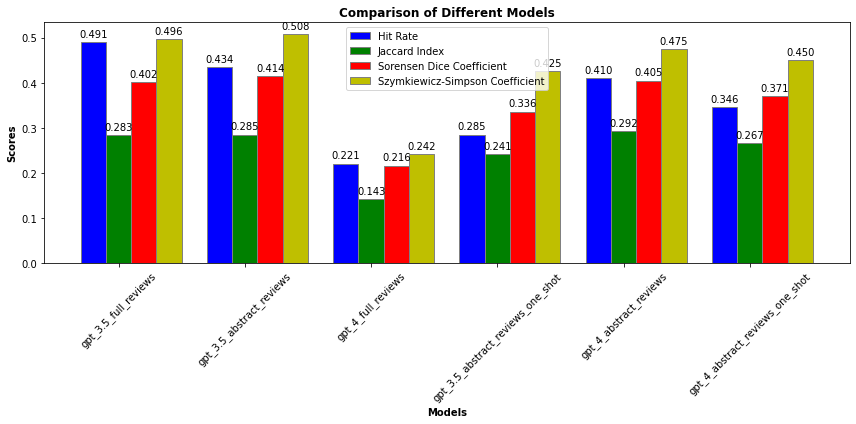

In [6]:
# Extracting data
data = results

models = list(data.keys())
hit_rates = [data[model]['hit_rate'] for model in models]
jaccard_indices = [data[model]['jaccard_index'] for model in models]
sorensen_dice_coefficients = [data[model]['sorensen_dice_coefficient'] for model in models]
szymkiewicz_simpson_coefficient = [data[model]['szymkiewicz_simpson_coefficient'] for model in models]

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2

# Positions for bars
r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]
r4 = [x + bar_width*3 for x in r1]

# Plotting bars
ax.bar(r1, hit_rates, color='b', width=bar_width, edgecolor='grey', label='Hit Rate')
ax.bar(r2, jaccard_indices, color='g', width=bar_width, edgecolor='grey', label='Jaccard Index')
ax.bar(r3, sorensen_dice_coefficients, color='r', width=bar_width, edgecolor='grey', label='Sorensen Dice Coefficient')
ax.bar(r4, szymkiewicz_simpson_coefficient, color='y', width=bar_width, edgecolor='grey', label='Szymkiewicz-Simpson Coefficient')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

bars = ax.patches
add_labels(bars)

# Adding labels
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of Different Models', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(models))])
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# # Extracting data
# data = results

# metrics = ['hit_rate', 'szymkiewicz_simpson_coefficient', 'jaccard_index', 'sorensen_dice_coefficient']
# models = list(data.keys())
# values = {metric: [data[model][metric] for model in models] for metric in metrics}

# # Plotting
# fig, axs = plt.subplots(4, 1, figsize=(10, 30))

# for i, metric in enumerate(metrics):
#     axs[i].bar(models, values[metric], color=plt.cm.Paired(range(len(models))))
#     axs[i].set_title(metric)
#     axs[i].set_ylabel('Score')
#     axs[i].set_xticklabels(models, rotation=45, ha='right')

# plt.tight_layout()
# plt.show()